# Exercise 1: Fourier series, Fourier transform, and signals

**Motivation**:
 * essential in Geophysics/Seismology
 * understand the purpose and basics of the most important principle of the digital universe

**Purpose of this notebook:**
 * from theory to practice
 * understand Fourier series - the **basis** of Fourier transformation (FT)
 * decompose a signal' into frequencies - **the** Fourier transformation
 * when using sampled signals, learn the limits of the **Discrete** Fourier transformation (DFT)
 * apply DFT to a real signal: a seismogram


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose-of-the-Fourier-transformation" data-toc-modified-id="Purpose-of-the-Fourier-transformation-1">Purpose of the Fourier transformation</a></span></li><li><span><a href="#Fourier-series" data-toc-modified-id="Fourier-series-2">Fourier series</a></span><ul class="toc-item"><li><span><a href="#The-Fourier-series-and-its-coefficients" data-toc-modified-id="The-Fourier-series-and-its-coefficients-2.1">The Fourier series and its coefficients</a></span></li><li><span><a href="#Determine-$a_k$-and-$b_k$" data-toc-modified-id="Determine-$a_k$-and-$b_k$-2.2">Determine $a_k$ and $b_k$</a></span></li></ul></li><li><span><a href="#Excursion:-Representing-&amp;-illustrating-oscillations" data-toc-modified-id="Excursion:-Representing-&amp;-illustrating-oscillations-3">Excursion: Representing &amp; illustrating oscillations</a></span></li><li><span><a href="#The-Fourier-transform" data-toc-modified-id="The-Fourier-transform-4">The Fourier transform</a></span></li><li><span><a href="#Discrete-Fourier-Transform-(DFT)" data-toc-modified-id="Discrete-Fourier-Transform-(DFT)-5">Discrete Fourier Transform (DFT)</a></span><ul class="toc-item"><li><span><a href="#Sampling-theorem" data-toc-modified-id="Sampling-theorem-5.1">Sampling theorem</a></span></li><li><span><a href="#Spectral-leakage-&amp;-windowing/tapering" data-toc-modified-id="Spectral-leakage-&amp;-windowing/tapering-5.2">Spectral leakage &amp; windowing/tapering</a></span></li></ul></li><li><span><a href="#DFT-of-actual-measured-signals:-seismograms" data-toc-modified-id="DFT-of-actual-measured-signals:-seismograms-6">DFT of actual measured signals: seismograms</a></span><ul class="toc-item"><li><span><a href="#Short-time-Fourier-transform-(&quot;Spectrogram&quot;):-visualize-time-varying-frequency-information" data-toc-modified-id="Short-time-Fourier-transform-(&quot;Spectrogram&quot;):-visualize-time-varying-frequency-information-6.1">Short-time Fourier transform ("Spectrogram"): visualize time-varying frequency information</a></span></li></ul></li></ul></div>

In [17]:
# Prepare: load packages, set some basic options  
%matplotlib inline

# Standard libraries
import numpy as np

# Plotting library
import matplotlib
import matplotlib.pylab as plt
import ipywidgets

# Seismological tools
from obspy.signal.invsim import cosine_taper 

# Set up plotting
# plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = 15, 3
plt.rcParams['figure.dpi'] = 100

## Purpose of the Fourier transformation

Transforms a signal from the **time domain** into the **frequency domain** = split up the **signal** (*time series, waveform, stock prices, etc.*), and separate the content at **each frequency**.

* --> analyze signal according to **energy content per frequency** = extract amplitude information at each frequency, which contributes to the measured signal
* --> get a receipt of the ingredients to recreate/blend the signal (inverse Fourier transformation)

<!-- ![](images/FT_principle_aavos.gif "Principle of Fourier Transformation") -->
<div style="width: 600px; margin-left: auto; margin-right: auto;">
    <img src="images/FourierTransform_principle_aavos.gif">
    <div style="text-align: right">
        Source: <a href=https://aavos.eu/glossary/fourier-transform>AAVOS</a>
    </div>
</div>
<!-- Actual source: https://web.archive.org/web/20200919054306/https://aavos.eu/glossary/fourier-transform/ -->

<br>

--- 

But let's get there step by step.

It is based on:

## Fourier series

= approximate an (unknown) function $f(x)$ by another function $g_N(x)$
* $g_N(x)$ consists of a sum over $N$ basis functions weighted by some coefficients
* basis functions need to be orthogonal

<br>

$\sin$ and $\cos$ functions are convenient basis functions because any signal can be separated into several sinusoidal paths.

In the period range of $[-T/2 ; T/2]$, the *Fourier series* is defined as:

$$
f(t) \approx g_N(t) = \frac{1}{2} a_0 + \sum_{k=1}^N \left[ a_k \cos \left(\frac{2\pi k t}{T} \right) + b_k \sin\left(\frac{2\pi k t}{T}\right)\right]
$$
$$ a_k = \frac{2}{T} \int_{-T/2}^{T/2} f(t) \cos\left(\frac{2\pi k t}{T}\right)dt $$
$$ b_k = \frac{2}{T} \int_{-T/2}^{T/2} f(t) \sin\left(\frac{2\pi k t}{T}\right)dt $$

The Fourier series allows us to approximate any **continuous, periodic and infinite function**.
The more basis functions we use (larger $N$), $f(t)$, the better we can approximate $f(t)$ (i.e., $g_N(t)$ becomes more similar to $f(t)$.

Let's do that (also step-by-step).

---

### The Fourier series and its coefficients 

The following code cell defines a function to **create a (periodic) signal** given $a_k$ and $b_k$.

In [18]:
# Code by Giulio Ghirardo [https://stackoverflow.com/a/27720302]

def series_real_coeff(a0, a, b, t, T):
    """
    Calculates the Fourier series with period T at times t,
    from the real coeff. a0,a,b
    """
    tmp = np.ones_like(t) * a0 / 2.
    for k, (ak, bk) in enumerate(zip(a, b)):
        tmp += ak * np.cos(2 * np.pi * (k + 1) * t / T) + \
               bk * np.sin(2 * np.pi * (k + 1) * t / T)
    return tmp

We will create a (periodic) signal $f(t)$ using Fourier series.

We could, in principle, create *any* periodic signal we want, but the following example is restricted in $N$ (limited details) and the value range of $a_k$ and $b_k$ (limited amplitude and phase).

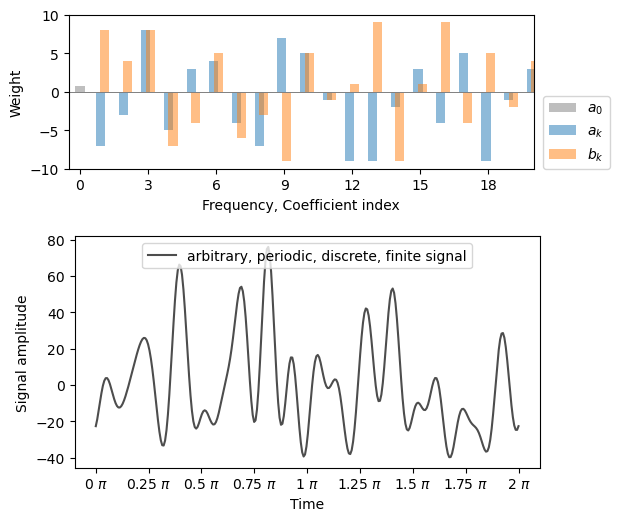

In [19]:
# -- Create & plot periodic, discrete, finite signal

# Temporal properties of the signal
nsamp = 300         # number of samples (intial value: 300)

# Create vectors
t = np.linspace(start=0, stop=nsamp, num=nsamp)  # time axis

def plot_coeff_signal(a0, a, b):

    sig = series_real_coeff(a0, a, b, t, 1.0)  # create periodic signal

    # Plotting
    fig, ax = plt.subplots(nrows=2, figsize=(6,6), gridspec_kw=dict(height_ratios=(2, 3), hspace=0.35))
    
    ax[0].bar(0, a0, width=0.4, color='0.5', alpha=0.5, label='$a_0$')
    ax[0].bar(fk - 0.1, a, width=0.4, color='C0', alpha=0.5, label='$a_k$')
    ax[0].bar(fk + 0.1, b, width=0.4, color='C1', alpha=0.5, label='$b_k$')
    ax[0].axhline(0, c='0.5', lw=0.7)
    ax[0].set_xlabel('Frequency, Coefficient index')
    ax[0].set_ylabel('Weight')
    ax[0].set_xlim(-0.5, Nk)
    ax[0].set_ylim(-10, 10)
    ax[0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    ax[0].legend(loc=(1.02, 0))

    ax[1].plot(t / nsamp * 2, sig, '0.3', label='arbitrary, periodic, discrete, finite signal')
    ax[1].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
    # ax[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1.0))
    # ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Signal amplitude')
    ax[1].legend(loc=9)
    
    ll, bb, ww, hh = ax[1].get_position().bounds
    ax[1].set_position([ll + 0.01, bb, ww, hh])  # reserve some space for long ticklabels
    # plt.tight_layout(pad=0.4)
    plt.show()
    
    return sig


# Specify coefficients
Nk = 20       # number of coefficients (default: 20)
a0 = 0.815    # offset amplitude of signal
fk = np.arange(1, Nk + 1)  # frequency axis (here: coefficient index)

# Random coefficients (i.e., weighting factors/amplitude for each component)
seed = None  # always construct a different signal
# seed = 0   # always construct the same signal
rng = np.random.default_rng(seed)
a = rng.integers(-10, high=10, size=Nk)  # random natural numbers up to 10
b = rng.integers(-10, high=10, size=Nk)
# a = rng.exponential(1, size=Nk)  # exponentially distributed values
# b = rng.exponential(1, size=Nk)

# # Specific coefficients to explore them (create a custom signal)
# # NOTE: indexing starts at 0 (i.e., a[0] is the FIRST coefficient)
# a = np.zeros(Nk); b = np.zeros(Nk)
# a[0] = -2; a[8] = 2; a[11] = -1; a[18] = -2
# b[3] = 4; b[6] = -3; b[15] = 1

sig = plot_coeff_signal(a0, a, b)

> Play around and experiment! (change values, re-execute cell)

---


Once you like your signal, let's call it $f(t)$; we want to **approximate** it with $g_N(t)$, so we only use coefficients until $N$:

In [20]:
# Determine the first 'n' coefficients of the function using the code function of cell 1

def plot_approximate_series(N):
    """
    n: number of coefficients used to reconstruct f(t)
    """
    
    g = series_real_coeff(a0, a[:N], b[:N], t, 1.0)  # create periodic signal

    fig, ax = plt.subplots(nrows=2, figsize=(6, 6), gridspec_kw=dict(height_ratios=(3, 2), hspace=0.15))
    
    # Plotting
    plt.sca(ax[0])
    plt.plot(t/nsamp*2, sig, '0.6', lw=1.8, label='$f(x)$: original')  # normalized 
    plt.plot(t/nsamp*2, g, 'crimson', ls='--', label='$g(x)$: reconstruction')

    plt.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
    plt.legend(loc=1)
    
    plt.sca(ax[1])
    plt.plot(t/nsamp*2, g-sig, 'crimson', label='$g(x) - f(x)$')
    plt.tick_params(bottom=False, labelbottom=False, top=True)
    plt.xlabel('Time')
    plt.ylabel('Amplitude Difference')
    plt.legend(loc=1)
    
    plt.show()


interactive_plot = ipywidgets.interactive(  # continuous update
# interactive_plot = ipywidgets.interact_manual(  # restrict execution to button
    plot_approximate_series, N=(1, Nk, 1))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

> Before adjusting the slider, what do you observe? Do we reconstruct the signal?

> Increase (or decrease) $N$. What do you observe now and why? 

> Generate another $f(t)$ and repeat.

---

To better see the influence of $a_k$ and $b_k$, let's change them individually for only two values of $k$ interactively:

In [21]:
# Make an interactive version of the above
# [https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html]

def plot_coeff_signal_wrap(a0, i1, a1, b1, i2, a2, b2):
    a = np.zeros(Nk)
    b = np.zeros(Nk)
    a[i1-1] = a1  # -1 considers that indexing starts at 0 (i.e., a[0] is the FIRST coefficient)
    b[i1-1] = b1
    a[i2-1] = a2
    b[i2-1] = b2
    plot_coeff_signal(a0, a, b)


a0 = ipywidgets.FloatSlider(0, min=-10, max=10, description='a0', continuous_update=False)
i1 = ipywidgets.IntSlider(1, 1, 20, description='i1', continuous_update=False)
a1 = ipywidgets.IntSlider(1, -10, 10, description='a[i1]', continuous_update=False)
b1 = ipywidgets.IntSlider(1, -10, 10, description='b[i1]', continuous_update=False)
i2 = ipywidgets.IntSlider(5, 1, 20, description='i2', continuous_update=False)
a2 = ipywidgets.IntSlider(1, -10, 10, description='a[i2]', continuous_update=False)
b2 = ipywidgets.IntSlider(1, -10, 10, description='b[i2]', continuous_update=False)
interactive_plot = ipywidgets.interactive_output(
    plot_coeff_signal_wrap, {k: globals()[k] for k in {'a0', 'i1', 'a1', 'b1', 'i2', 'a2', 'b2'}}
)
display(ipywidgets.VBox([a0, ipywidgets.HBox([i1, a1, b1]), ipywidgets.HBox([i2, a2, b2])]), interactive_plot)

Output()

> Play around with the sliders to adjust the signal.

> Do you notice something?
> <details>
    <summary>(<b>click to reveal</b>)</summary>
    <i style="color: #CCCCCC">
        It's difficult to control the signal, i.e., create a <b>desired</b> signal by hand.
    <p>
    This difficulty is because $a_k$ and $b_k$ do not represent some intuitive quantities (but they encode them). More on that later!.
    </i>
</details>

---

### Determine $a_k$ and $b_k$

For a periodic signal $f(t)$, we can determine $a_k$ and $b_k$ by calculating the integral specified above - separately for each $k$.

The following code cell defines a functions to do that for a given (periodic) signal.

In [22]:
# Code by Giulio Ghirardo [https://stackoverflow.com/a/27720302]

def fourier_series_coeff(f, T, N):
    """
    Calculates the first 2*N+1 Fourier series coeff. of a periodic function.

    Given a periodic, function f(t) with period T, this function returns the
    coefficients a0, {a1,a2,...},{b1,b2,...} such that:

    f(t) ~= a0/2+ sum_{k=1}^{N} ( a_k*cos(2*pi*k*t/T) + b_k*sin(2*pi*k*t/T) )
    
    Parameters
    ----------
    f : the periodic function, a callable like f(t)
    T : the period of the function f, so that f(0)==f(T)
    N_max : the function will return the first N_max + 1 Fourier coeff.

    Returns
    -------
    a0 : float
    a,b : numpy float arrays describing respectively the cosine and sine coeff.
    """
    # From Nyquist theorem we must use a sampling freq. larger than the maximum
    # frequency you want to catch in the signal
    f_sample = 2 * N
    
    # We also need to use an integer sampling frequency, or the points will not
    # be equispaced between 0 and 1. We then add +2 to f_sample
    t, dt = np.linspace(0, T, f_sample + 2, endpoint=False, retstep=True)
    y = np.fft.rfft(f) / t.size
    y *= 2
    return y[0].real, y[1:-1].real[0:N], -y[1:-1].imag[0:N]

Let's calculate $a_k$ and $b_k$:

In [23]:
# Determine 'n' coefficients of f(t)
T = 1         # period
NX = 20       # number of coeffs to reconstruct

a0X, aX, bX = fourier_series_coeff(sig, T, NX)
aX = aX.astype(int)
bX = bX.astype(int)
print('a0 = ', int(a0X))
print('ak =', aX)
print('bk =', bX)

a0 =  4
ak = [-50 -21  57 -38  19  28 -34 -50  44  35 -13 -66 -53 -19  23 -16  28 -56
  -4  29]
bk = [ 57  28  54 -49 -29  33 -41 -17 -65  35  -4  18  70 -62   8  67 -35  47
 -14  22]


The following animation of the *Fourier series* illustrates what we just did:
<details>
    <summary>(<b>click to reveal</b>)</summary>
    <div style="width: 500px; margin-left: auto; margin-right: auto">
<!--         <img src="images/FT_principle_ani_wiki.gif" style="width:100%"> -->
        <img src="https://upload.wikimedia.org/wikipedia/commons/2/2b/Fourier_series_and_transform.gif" style="width:100%">
        <div style="text-align: right">
            Source: <a href=https://en.wikipedia.org/wiki/Fourier_transform>wikipedia: Fourier transform</a>
        </div>
    </div>
    <!-- Actual source: https://en.wikipedia.org/wiki/File:Fourier_transform_time_and_frequency_domains_(small).gif -->
</details>

> So what did we do?
> <details>
    <summary>(<b>click to reveal</b>)</summary>
    <i style="color: #CCCCCC">
    We <b>decomposed</b> our signal $f(x)$ into harmonic sinusoids of different frequencies that are present in $f(t)$; they have specific amplitudes (and phase shifts).
    </i>
</details>

> What *can* we do with it?
> (**execute the next cell for the answer**)

In [24]:
g = series_real_coeff(a0X, aX, bX, t, T)

factor = max(sig) / max(g)  # normalization factor (to correct to original amplitude)
# factor = 1                  # don't normalize

# Plotting
plt.plot(t, sig, '0.5', lw=1.8, label='$f(x)$: original')  # normalized 
plt.plot(t, g * factor, 'crimson', ls='--', label='$g_N(x)$: approximation')

plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend(loc=1)
plt.show()

<!-- > Set `factor = 1` to not normalize $g(x)$. What do you see now and can you explain it? -->

> <details>
    <summary>(<b>click to reveal</b>)</summary>
    <i style="color: #CCCCCC">
    We can <b>approximate</b> $f(x)$ as a Fourier series with the decomposed harmonic sinusoids.
    <p>
    Why is the approximation so good (in fact, $g_N(t)$ reconstructs $f(t)$)?
    <details>
    <summary>(<b style="color: #777777">click to reveal</b>)</summary>
    Because the original number of basis functions was finite ($N = 20$)
    <p>
    We can now do the same what we explored before with our Fourier series: reduce $n$ and repeat the approximation.
    </details>
</details>

## Excursion: Representing & illustrating oscillations

Let's simplify the math: we can make use of Euler's formula (exponential form):

$$ e^{i \frac{2\pi}{T} k t} =\cos\left(\frac{2\pi}{T} k t\right)+i\sin\left(\frac{2\pi}{T} k t\right)$$

i.e., each complex exponential of the $k^{th}$ harmonic can be expressed as:
* a **cos**ine wave of the $k^{th}$ harmonic for the **real component**; plus
* a **sin**e wave of same the $k^{th}$ harmonic for the **imaginary component**.

Graphical illustration ($\theta = \frac{2\pi}{T} k t$):
<div style="width: 700px; margin-left: auto; margin-right: auto; display: flex; padding: 10px">
    <div style="flex: 50%; width:70%">
<!--             <img src="images/Unit-circle_cos_sin_complex" style="width:100%"> -->
        <img src="https://upload.wikimedia.org/wikipedia/commons/8/8d/Sinus_und_Kosinus_am_Einheitskreis_3.svg"  style="width:90%">
<!--             <img src="https://upload.wikimedia.org/wikipedia/commons/1/1a/Fourier_series_square_wave_circles_animation.gif" style="width:100%"> -->
    </div>
    <div style="flex: 50%">
<!--             <img src="images/Unit-circle_cos_sin_animation.gif" style="width:100%"> -->
        <img src="https://upload.wikimedia.org/wikipedia/commons/3/3b/Circle_cos_sin.gif" style="width:100%">
<!--          -->
    <div style="text-align: right">
        Source: <a href=https://en.wikipedia.org/wiki/Sine_and_cosine>wikipedia: Sine and cosine</a>
    </div>
    </div>
</div>
<!-- Actual source: https://en.wikipedia.org/wiki/File:Fourier_transform_time_and_frequency_domains_(small).gif -->


<!-- TODO: integrate some more explanations from: https://jackschaedler.github.io/circles-sines-signals/euler.html -->
<!--  + https://en.wikipedia.org/wiki/Fourier_transform#Use_of_complex_sinusoids_to_represent_real_sinusoids -->


What do we learn from that:
1. $\sin$ and $\cos$ *together* describe a point on the unit circle - with a distance to the origin (here 1) and an angle $\theta$;
2. adding $t$ then defines a rotation on the unit circle;
3. this rotation can be compactly represented by $e^{i\theta}$;
4. $k$ defines how fast it spins.

So the *Fourier series* becomes a sum of complex exponentials:

$$ g_{_{N}}(t)=\sum _{k=-N}^{N}c_{k}\cdot e^{i \frac{2\pi}{T} kt}$$

(Negative values of $k$ correspond to negative frequency for mathematical convenience).
For more info, check out [en.wikipedia.org/wiki/Fourier_transform#Use_of_complex_sinusoids_to_represent_real_sinusoids](https://en.wikipedia.org/wiki/Fourier_transform#Use_of_complex_sinusoids_to_represent_real_sinusoids).

Using this exponential form, each *Fourier coefficient* $c_k$ is a complex number (imagine $c_k = a_k + ib_k$), which in turn can be represented as:
* $|c_k|$, i.e., the absolute value (radius): the amplitude of the corresponding frequency;
* $arg(c_k)$, i.e., the argument (angle): the phase of the corresponding frequency.

Effectively, we transformed Cartesian coordinates ($c_k$) to **Polar coordinates** $|c_k|$ and $arg(c_k)$.
Those are much more intuitive than $a_k$ & $b_k$.
<!-- which is the reason why previously we could not easily adjust the signal as we desired. -->

To get back to $a_k$ & $b_k$, simply go from Polar to Cartesian coordinates:
* $a_k = |c_k| \cos(arg(c_k))$
* $b_k = |c_k| \sin(arg(c_k))$


Representing $|c_k|$ and $arg(c_k)$ on a unit circle helps to visualize how the *Fourier series* is composed:

<!-- NOTE: SVGs need to be in a div with "width:100%", otherwise they disappear [https://stackoverflow.com/a/62710469] -->
<details>
    <summary>(<b>click to reveal</b>)</summary>
    <div style="width: 700px; margin-left: auto; margin-right: auto; display: flex; padding: 10px">
        <div style="flex: 50%; width:100%">
<!--             <img src="images/FourierSeries_ani_circles_square.svg" style="width:100%"> -->
            <img src="https://upload.wikimedia.org/wikipedia/commons/b/bd/Fourier_series_square_wave_circles_animation.svg"  style="width:100%">
<!--             <img src="https://upload.wikimedia.org/wikipedia/commons/1/1a/Fourier_series_square_wave_circles_animation.gif"  style="width:100%"> -->
        </div>
        <div style="flex: 50%; width:100%">
<!--             <img src="images/FourierSeries_ani_circles_sawtooth.svg" style="width:100%"> -->
            <img src="https://upload.wikimedia.org/wikipedia/commons/1/1e/Fourier_series_sawtooth_wave_circles_animation.svg" style="width:100%">
    <!--          -->
        <div style="text-align: right">
            Source: <a href=https://en.wikipedia.org/wiki/Fourier_series>wikipedia: Fourier series</a>
        </div>
        </div>
    </div>
    <!-- Actual source: https://en.wikipedia.org/wiki/File:Fourier_transform_time_and_frequency_domains_(small).gif -->
</details>

So a signal $f(t)$ can be described by a sum of those circles, each rotating with a specific frequency $\theta$, $|c_k|$ (amplitude) and $arg(c_k)$ (phase).

---

We can visualize $|c_k|$ (amplitude) and $arg(c_k)$ of our signal, i.e. the **amplitude spectrum** and **phase spectrum**:

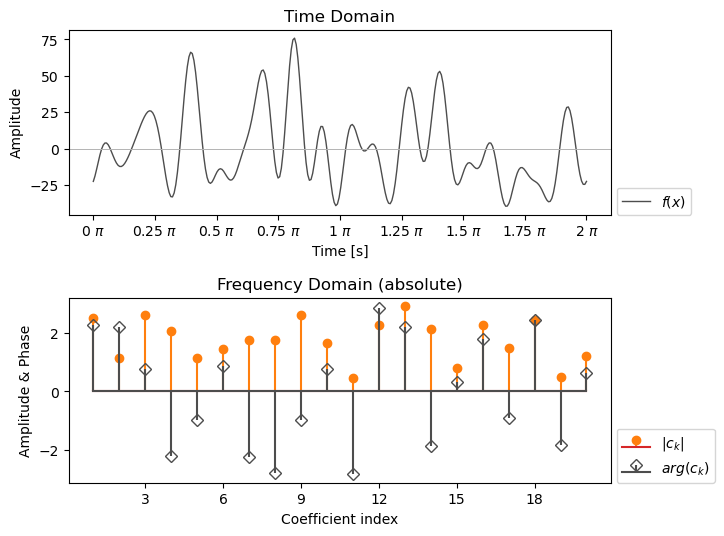

In [25]:
ck = np.vectorize(complex)(aX, bX)
fkX = np.arange(1, NX + 1)

fig, ax = plt.subplots(nrows=2, figsize=(7, 6), gridspec_kw=dict(height_ratios=(2, 2), hspace=0.45))

# Plot signal
plt.sca(ax[0])
plt.title('Time Domain')

plt.plot(t/nsamp*2, sig, '0.3', lw=1.0, label='$f(x)$')
plt.axhline(0, c='0.7', lw=0.7)

plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
# plt.xlim(0, 50) 
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc=(1.01,0))

# Showing magnitude/amplitude (absolute value) & phase/angle (argument) of the complex value
plt.sca(ax[1])
plt.title('Frequency Domain (absolute)')

ml, sl, bl = plt.stem(fkX, 10/nsamp * np.abs(ck), linefmt='-', label='$|c_k|$')  # arbitrary scaling for nice visual
sl.set_color('C1')
ml.set_markerfacecolor('C1')
ml.set_markeredgecolor('C1')
ml, sl, bl = plt.stem(fkX, np.angle(ck), label='$arg(c_k)$', markerfmt='D')  # angle in complex place [-pi, pi]
sl.set_color('0.3')
ml.set_markerfacecolor('None')
ml.set_markeredgecolor('0.3')

plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
bl.set_color('0.3')
# plt.xlim(0, nsamp / 2)                                
plt.xlabel('Coefficient index')
plt.ylabel('Amplitude & Phase')
plt.legend(loc=(1.01, 0));

> Do you notice some similarity of $|c_k|$ to $a_k$ and $b_k$ (compare with the first plot at [The Fourier series and its coefficients](#The-Fourier-series-and-its-coefficients))?

---

What you learned:
* any (periodic) signal $f(t)$ can be created by simply combining harmonic signals of various periods/frequencies and phase information;
* the higher the coefficient index $k$ goes, the more details we can represent.


Until now, $f(t)$ was periodic, but *Fourier series* **cannot** represent **non-periodic signals**, i.e., signals that do not repeat like they occur in nature.

But we can do something else...

## The Fourier transform

... it allows us to switch between the two representations:

time domain (*samples*) $\qquad\leftrightarrow\qquad$ frequency domain (*oscillations of different frequency with associated amplitude and phase*)

For a **non-periodic function**, $T \rightarrow \infty $ (i.e., the periodicity, or length of $f(t)$, tends to infinity).
So the set of frequencies becomes continuous (differences between neighboring frequencies become infinitely small).

The infinite sum of the *Fourier series* turns into an integral:

$$
f(t) =  \int_{-\infty}^{\infty} F(\omega)e^{i\omega t}dt \qquad\leftrightarrow\qquad
F(\omega) = \frac{1}{2\pi} \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt
$$

So we do not have basis functions $k$ anymore, but frequencies $\omega = 2\pi f$; $c_k$ became $F(\omega)$ -- the ***Fourier transform***.


<!-- Attention: sign and factor conventions can be different in the literature! -->

In practice (in the digital world), we do **not have continuous but discrete** (sampled) signals with sample size $N$, i.e., $ 2\pi f = \frac{2\pi}{T} = \frac{2\pi}{N}$, so we need to work with the _**discrete** Fourier transformation_.

$$
f_k = \sum_{n=0}^{N-1} F_k e^{i\frac{2\pi}{N} k n} \qquad\leftrightarrow\qquad
F_k = \frac{1}{N} \sum_{n=0}^{N-1} f_k e^{-i\frac{2\pi}{N} k n }, \qquad \forall k \in \{0, \ldots, N-1\},
$$



So $F_k$ is the analog to:
* $F(\omega)$ of the continuous case (Fourier transform);
* $c_k = a_k + ib_k$ of the the *Fourier series*.


(i.e., we have to calculate each $F_k$).

<!-- TODO: visual explanation: https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/ -->


---

Further and more detailed explanations on *Fourier series* and *Fourier transformations* can be found
* [jezzamon.com/fourier](https://www.jezzamon.com/fourier/index.html) -- illustrates decomposition of any 1D and 2D signal
* [betterexplained.com/.../interactive-guide-to-the-fourier-transform](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/)
* [jackschaedler.github.io/circles-sines-signals](https://jackschaedler.github.io/circles-sines-signals)


---

So let's get discrete...

## Discrete Fourier Transform (DFT)

### Sampling theorem

First, we need to define some terms characterizing the sampling of signals:
* *sampling interval*: temporal distance $\Delta t$ between each sampled value. On the time axis, sample $n$ has position $t = n\Delta t$ with $k=[1,2, ..., N]$;
* *period* (or duration of signal): $T = N\Delta t$;
* *sampling rate* (or *sampling frequency*): $\Delta f = 1/\Delta t$.   

The *Sampling theorem* states: to correctly reproduce the highest frequency of a signal, at least 2 samples per period are needed.
Give a look at the following animation: [jackschaedler.github.io/circles-sines-signals/sampling.html](https://jackschaedler.github.io/circles-sines-signals/sampling.html)

In other words: A signal can only be reproduced properly when it does not contain frequency components above half of the sampling frequency. This limit is called the *Nyquist frequency*:

$$ f_{Ny} = \frac{1}{2\Delta t} = \frac{\Delta f}{2}$$

Give a look at the following animation: [jackschaedler.github.io/circles-sines-signals/sampling2.html](https://jackschaedler.github.io/circles-sines-signals/sampling2.html)
 
In yet other words: **if we want to capture a certain (upper) frequency $f$ in the signal, the sampling frequency needs to be $\Delta f = 2 f$**.
 
<!-- **Important consequence of this theorem**: need low-pass data *before* resampling them to a lower sample rate. The corner frequency of the low-pass filter is maximum the Nyquist frequency of the *new* sample rate. If this necessity is not considered, we obtain *aliasing* effects. -->

Noted.

---

Another important aspect...

### Spectral leakage & windowing/tapering

Let us now create a simple, non-periodic, and discrete (non-continuous) signal of a certain frequency.
We sample it with 100 Hz.

Then we perform the Fourier transformation and inspect the *amplitude* spectrum.

Notes:
* To simulate non-periodicity, we simply shorten the time axis slightly (by 1%), so that the last sample value differs from the first;
* The DFT gives us only the Fourier coefficients up to the Nyquist frequency (see above why).
* In practice, the transformation is performed as *Fast* Fourier transformation (FFT)

> Before looking at the output of the cell, what would you expect in the frequency-domain plot?
<!--  a delta pulse at this frequency -->

In [26]:
# Demonstrating spectral leakage and windowing/tapering

def generate_sine(length, freq):
    
    length *= 0.99   # create a non-periodic signal
    
    dt = 1 / 100               # sampling interval/frequency
    # nsamp = int(length / dt)  # number of samples
        
    t = np.arange(0, length, dt)            # time axis
    # t = np.linspace(0, length, nsamp + 1)
    
    # Create signal
    sig = np.sin(2 * np.pi * freq * t)     # sine wave of particular frequency
    
    return t, sig
    

def plot_sig_spectrum(t, sig, padding_factor, taper, taper_perc, logfy, logfx, kw_line=None):

    nsamp = sig.size  # equiv
    dt = np.diff(t[:2])[0]

    # Taper signal
    if 'None' not in taper:
        if taper == 'Cosine':
            tap_win = taper_dict[taper](nsamp, taper_perc)
        else:
            tap_win = taper_dict[taper](nsamp)
        sig_tap = sig * tap_win

    # Pad signal
    if padding_factor > 0:
        zeropad_samps = int(nsamp * padding_factor)
        sig = np.pad(sig, (0, zeropad_samps))  # pad original
        if 'None' not in taper:
            sig_tap = np.pad(sig_tap, (0, zeropad_samps))  # also pad tapered
        nsamp = sig.size  # update nsamp
        # t = np.arange(0, nsamp * dt, dt)  # update (extend) time axis
        t = np.linspace(0, nsamp * dt, nsamp)  # more robust

    # FFT to frequency domain
    Fsig = np.fft.rfft(sig, n=nsamp)       
    if 'None' not in taper:
        Fsig_tap = np.fft.rfft(sig_tap, n=nsamp)

    # Create frequency axis
    fNy = 1 / (2 * dt)                        # Nyquist frequency
    # f = np.linspace(0, fNy, nsamp//2 + 1)  # frequency axis
    f = np.fft.rfftfreq(nsamp, d=dt)  # equiv

    fig, ax = plt.subplots(nrows=2, figsize=(7, 6), gridspec_kw=dict(height_ratios=(2, 2), hspace=0.45))

    # Plotting
    plt.sca(ax[0])
    plt.title('Time Domain')
    plt.axhline(0, c='0.7', lw=0.7)
    plt.plot(t[:sig.size], sig, '0.3', lw=0.7, label='$f(x)$', **kw_line)
    if 'None' not in taper:
        plt.plot(t, sig_tap, 'C1', label='$f(x)$ tapered')
        plt.plot(t[:tap_win.size], tap_win * sig.max(), 'k', ls='--', lw=0.7, label='%s taper' % taper)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend(loc=(1.01,0))

    plt.sca(ax[1])
    plt.title('Frequency Domain')
    plt.plot(f, 2.0/nsamp * np.abs(Fsig), '0.3', lw=0.7, label='$F(\omega)$', **kw_line)
    if 'None' not in taper:
        plt.plot(f, 2.0/nsamp * np.abs(Fsig_tap), 'C1', lw=1.0, label='$F(\omega)$ with taper')
    plt.xlim(0.01 if logfx else 0, fNy)                                
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('|F(f)|')
    plt.legend(loc=(1.01, 0))
    plt.gca().set_yscale('log' if logfy else 'linear')
    plt.gca().set_xscale('log' if logfx else 'linear')

    plt.show()


def demo_leakage_taper(length, freq, padding_factor, taper, taper_perc, logfy, logfx):
    
    t, sig = generate_sine(length, freq)
    
    kw_line = dict(marker='.', ms=3)
    plot_sig_spectrum(t, sig, padding_factor, taper, taper_perc, logfy, logfx, kw_line)


taper_dict = {
    'None (Box-car)': None,
    'Hanning': np.hanning,
    'Hamming': np.hamming,
    'Bartlett': np.bartlett,
    'Cosine': cosine_taper,
}

# length = 5           # length of signal in seconds (initial: 2 s)
# freq = 10             # frequency of sine wave
# taper = 'Hanning'    # type of taper window
# padding_factor = 0   # how much to zero pad signal
# logy = False         # whether to show amplitude spectrum on log scale

# demo_leakage_taper(length, freq, taper, padding_factor, logy)


# Interactive
length = ipywidgets.IntSlider(5, 1, 20, description='Length', continuous_update=False)
freq = ipywidgets.IntSlider(6, 1, 20, description='Sine freq.', continuous_update=False)
padding_factor = ipywidgets.FloatSlider(0, min=0, max=2, step=0.1, description='% zero pad', continuous_update=False)
taper = ipywidgets.Dropdown(options=taper_dict.keys(), continuous_update=False)
taper_perc = ipywidgets.FloatSlider(0.1, min=0, max=0.9, step=0.1, description='Cosine %', continuous_update=False)
logfy = ipywidgets.Checkbox(value=False, description='Log |F(f)| scale', continuous_update=False)
logfx = ipywidgets.Checkbox(value=False, description='Log freq. scale', continuous_update=False)

interactive_plot = ipywidgets.interactive_output(
    demo_leakage_taper, {k: globals()[k] for k in {'length', 'freq', 'padding_factor', 'taper', 'taper_perc', 'logfy', 'logfx'}}
)
display(ipywidgets.VBox([ipywidgets.HBox([length, freq]),
                         ipywidgets.HBox([padding_factor, logfy]),
                         ipywidgets.HBox([taper, taper_perc])]), interactive_plot)

Output()

> But what do you see actually in the frequency domain and why?
<!-- spectral leakage, the "smearing out" of the central frequency... because the Fourier transformation assumes an infinite signal. The finite length of the signal limits the frequency spacing: Δ𝑓=1/𝑇 -->

> Suppose we can measure the signal for a longer time (increase the length). What do you observe in the frequency domain and why?
<!-- the longer the signal, the more distinct becomes the frequency peak, less leakage/smearing, better resolution.  -->
<!-- long signals in time-domain mean good resolution in frequency-domain and vice versa (uncertainty principle) -->

In reality we cannot just enlarge the length of our signal. But we can artificially lengthen the signal with zero-padding.
<!-- it does not add information (other frequencies) but the signal length and can therefore increase the frequency resolution -->

> Reset the length and instead increase the zero padding factor... <br>
> Oops. What happened?

Let's introduce a taper.

> Select a taper window.

> Why do we need to taper the signal before performing the Fourier transformation (and before zero-padding)?
<!-- Real data usually do not end with the same sample amplitude as they start with. -->
<!-- -> the taper adjusts the last sample amplitude to the same value as the first one, traditionally to zero. -->
<!-- But gradually, not abruptly; otherwise we don't reduce the spectral leakage -->
<!-- It maintains/focuses on the signal in the middle part-->

> Why does the peak amplitude in the spectrum differ for the original and tapered *padded* signal?  
<!-- "throwing away" part of our signal and therefore loose information and energy. -->

<!-- > Which is the better taper for longer signals and why? -->
> What happens when you increase the percentage of Cosine tapering?
<!-- becomes smoother (sharper frequency resolution), but throw away more data -->
<!-- -> tapering needs to balance 1) keeping as much information as possible (minor taper) and 2) making the transition to 0 as gently as possible (stronger tapering) -->

**Summary**:
<details>
    <summary>(<b>click to reveal</b>)</summary>
    <i>
    Because the time series is finite and discretely sampled, the DFT is not equal to the FT. 
    <br>
    In practice, applying a taper is one of the most important pre-processing steps of spectral analysis of a signal.
    <br>
    Others important steps are demeaning/detrending, pre-filtering, temporally isolating the signal -- we'll apply some now and later in Exercise 2.
    </i>
</details>


## DFT of actual measured signals: seismograms

Let's load a seismogram of a local/regional event recorded at station [RJOB](https://orfeus-eu.org/stationbook/networks/BW/1980/stations/RJOB/2001/) in Bavaria, Germany.

[ObsPy](https://github.com/obspy/obspy/wiki/) makes it *veeery* easy to load, processes, and explore seismograms. In fact, it's the de-facto seismological (Python) framework, on which many other tools are based on). 

In [27]:
import obspy
from obspy.signal.filter import lowpass
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

In [28]:
# Read a seismogram
# [https://docs.obspy.org/tutorial/code_snippets/reading_seismograms.html]
# [https://docs.obspy.org/packages/autogen/obspy.core.stream.read.html]

# st_raw = obspy.read()  # read in example seismogram included in obspy
st_raw = obspy.read('http://examples.obspy.org/RJOB_061005_072159.ehz.new')  # GSE format
st_raw.plot();

In [29]:
def demo_seismogram_spectrum(seistype, tslice, padding_factor, taper, taper_perc, logfy, logfx):

    tr = st_types[seistype][0]
    tr = tr.slice(tr.stats.starttime + tslice[0],
                   tr.stats.starttime + tslice[1])
    t = tr.times() + tslice[0]
    sig = tr.data
    
    kw_line = dict()
    plot_sig_spectrum(t, sig, padding_factor, taper, taper_perc, logfy, logfx, kw_line)

st = st_raw.copy()  # don't touch the original (otherwise you have to load it again)
trange = [0, st[0].stats.delta * st[0].stats.npts]

st_types = {
    'differentiate: ACC': st.copy().differentiate(),  # accelerogram
    'original: VEL': st,  # velocity 
    'integrate: DISP': st.copy().integrate().detrend('spline', order=2, dspline=1000),  # displacement
}

# Pro tip: remove response and convert to DISP, ACC, or leave VEL
# (only works if stations's response infor is present in the stream)
# st.remove_response(output="VEL")

# Interactive
tslice = ipywidgets.IntRangeSlider(value=trange, min=0, max=trange[1], step=1, description='Time range', continuous_update=False)
seistype = ipywidgets.Dropdown(options=st_types.keys(), value='original: VEL', continuous_update=False)
padding_factor = ipywidgets.FloatSlider(0, min=0, max=2, step=0.1, description='% zero pad', continuous_update=False)
taper = ipywidgets.Dropdown(options=taper_dict.keys(), continuous_update=False)
taper_perc = ipywidgets.FloatSlider(0.1, min=0, max=0.9, step=0.1, description='Cosine %', continuous_update=False)
logfy = ipywidgets.Checkbox(value=False, description='Log |F(f)| scale', continuous_update=False)
logfx = ipywidgets.Checkbox(value=False, description='Log freq. scale', continuous_update=False)

interactive_plot = ipywidgets.interactive_output(
    demo_seismogram_spectrum, {k: globals()[k] for k in {'seistype', 'tslice', 'padding_factor',
                                                         'taper', 'taper_perc', 'logfy', 'logfx'}}
)
display(ipywidgets.VBox([ipywidgets.HBox([tslice, seistype]),
                         ipywidgets.HBox([padding_factor, logfy, logfx]),
                         ipywidgets.HBox([taper, taper_perc])]), interactive_plot)

Output()

Note: it's more useful to plot spectrum in with log frequency axis.

> Try to isolate the event.

> Then, apply a taper window. Do you notice a difference?

> Bonus: Use the differentiated or integrated signal. How does the spectrum change and why?


Notable to remember: also this waveform is composed of a superposition/summation of harmonic signals of various frequencies.
<!-- (the amplitude spectrum gives their amplitude; the phase information is not shown) -->

### Short-time Fourier transform ("Spectrogram"): visualize time-varying frequency information

So far, we analyzed a signal only in either time or frequency domain.
But we can look at both dimensions together - in the so-called spectrogram using short-time FT.

The spectrogram is especially useful to investigate the frequency content of longer or complex seismograms.

In [30]:
# -- Spectrogram

def plot_spectrogram(NFFT, perc_overlap, perc_padding, x_range, y_range, logfy, spec_mode):

    tr = st[0]
    n_overlap = int(NFFT * perc_overlap / 100)
    pad_to = int(NFFT * (1 + perc_padding / 100))
    
    fig, ax = plt.subplots(nrows=2, figsize=(7, 6), sharex=True, gridspec_kw=dict(height_ratios=(2, 2), hspace=0.45))

    sig = tr.data
    
    # Plot
    plt.sca(ax[0])
    plt.plot(tr.times(), sig, '0.3', lw=0.5)
    plt.xlabel('Time [sec]')
    plt.ylabel('Counts')
    # plt.ylabel('Velocity [m/s]')
    # plt.ylabel('Acceleration [m²/s]')

    plt.sca(ax[1])
    plt.title('Spectrogram; window length: %s samples' % NFFT)

    # [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html]
    # Pxx is the segments x freqs array of instantaneous power, freqs is
    # the frequency vector, bins are the centers of the time bins in which
    # the power is computed, and im is the matplotlib.image.AxesImage instance
    Pxx, freqs, bins, im = plt.specgram(
        sig, NFFT=NFFT, Fs=tr.stats.sampling_rate, 
        mode=spec_mode, # 'magnitude',  'psd', 'phase'
        noverlap=n_overlap, pad_to=pad_to,
        cmap=plt.cm.gist_heat
    )

    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    if logfy:
        if y_range[0] == 0:
            y_range = (0.01, y_range[1])
        plt.gca().set_yscale('log')
    else:
        plt.gca().set_yscale('linear')
    plt.xlim(*x_range)
    plt.ylim(*y_range)
    
    plt.show()

# Read a longer signal (12 hours)
# https://docs.obspy.org/tutorial/code_snippets/waveform_plotting_tutorial.html
# st = obspy.read('https://examples.obspy.org/COP.BHZ.DK.2009.050')  # pretty noisy
st = obspy.read('https://examples.obspy.org/GR.BFO..LHZ.2012.108')  # contains a M6.8 on the other side of the Earth

tr = st[0]
dt = tr.stats.sampling_rate
fNy = dt / 2  # Nyquist frequency
maxt = tr.times()[-1]

# NFFT = 256    # length of spectrogram window in sample points (initial: 256)
# perc_overlap = 50  # percentage of the sliding window that overlap
# x_range = (0, maxt)
# y_range = (0, fNy)
# logy = False
# plot_spectrogram(NFFT, n_overlap, x_range, y_range, logfy)

# Interactive
NFFT = ipywidgets.Dropdown(options=[2**x for x in range(8, 14)], description='NFFT', continuous_update=False)
perc_overlap = ipywidgets.IntSlider(0, min=0, max=90, step=5, description='% overlap', continuous_update=False)
perc_padding = ipywidgets.IntSlider(0, min=0, max=90, step=5, description='% zero pad', continuous_update=False)
x_range = ipywidgets.IntRangeSlider(value=[0, maxt], min=0, max=maxt, step=1, description='Time range', continuous_update=False)
y_range = ipywidgets.FloatRangeSlider(value=[0.001, fNy], min=0, max=fNy, step=0.01, description='Freq range', continuous_update=False)
logfy = ipywidgets.Checkbox(value=False, description='Log |F(f)| scale', continuous_update=False)
spec_mode = ipywidgets.Dropdown(options=['magnitude', 'psd', 'angle', 'phase'], description='Spec mode', continuous_update=False)

interactive_plot = ipywidgets.interactive_output(
    plot_spectrogram, {k: globals()[k] for k in {'NFFT', 'perc_overlap', 'perc_padding',
                                                 'x_range', 'y_range', 'logfy', 'spec_mode'}}
)
display(ipywidgets.VBox([ipywidgets.HBox([NFFT, perc_overlap, perc_padding, spec_mode]),
                         ipywidgets.HBox([x_range, y_range, logfy])]), interactive_plot)

Output()

> Explore!
<!-- curve from lower to higher frequencies: dispersion of the surface waves - just one application where spectrograms are helpful -->

In [31]:
# # Spectrogram using obspy
# # [https://docs.obspy.org/tutorial/code_snippets/plotting_spectrograms.html]
# st.slice(t1 + 30, t1+120).spectrogram(
#     per_lap=0.5,  # percentage of overlap
#     wlen=dt/100 * 1,  # NFFT [in seconds]
#     mult=8.0,  # zero padding factor (mult * wlen).
#     log=False,
# )

> What happens when you increase `NFFT` and why?
<!-- decreases the temporal resolution, but increases the frequency resolution (uncertainty principle)  -->
<!-- increasing NFFT also allows resolving lower frequencies (only visible in log scale) -->

> Does increasing the window overlap help in something and why?
<!-- yes, it increases the temporal resolution, because we can perform the FT more often, obtaining more windows, which overlap -->

> Does increasing the zero padding help in something and why?
<!-- yes, it gives more detail, especially for higher frequencies -->

# Credits

* Seismo-Live *Signal Processing* Jupyter notebooks: [seismo-live.github.io/...](https://seismo-live.github.io/tree/index.html)
* Warner Marzocchi's lecture slides
* Digital Signal Processing Lecture as Jupyter notebooks: [nbviewer.org/github/spatialaudio/digital-signal-processing-lecture/...](https://nbviewer.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/index.ipynb)
* IPython Cookbook Chapter 10.1: *Analyzing the frequency components of a signal*: [ipython-books.github.io/...](https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/)